## Steps  
1. Import libraries  
2. Prepare data  
   ```Download  |  Transform  |  Dataloader```  
3. Define parameters  
   ```Model  |  Optimizer  |  Loss  |  Training  ```
4. Build Model  
   ```Components  ```
5. Training loop  
6. Visualize results  

## Import libraries  

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import datetime

print(f"Imports completed at {datetime.datetime.now()}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Versions
print(f"Torch: {torch.__version__}, TorchVision: {torchvision.__version__}")

/home/jovyan/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-tk27u_9q because there was an issue with the default path (/home/jovyan/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No

Imports completed at 2025-08-22 16:31:57.871068
Using device: cuda
Torch: 2.5.1, TorchVision: 0.20.1


In [2]:
# Create output folder
folder_name = "wgan_dc_wc_generated_images"
os.makedirs(f"{folder_name}", exist_ok=True)

## Define parameters  

In [77]:
# Set seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Data prep params
batch_size = 128

# Model params
z_dim = 100     # Size of noise vector
img_dim = 28       # MNIST size
channels = 1        # Gray scale
img_shape = (channels, img_dim, img_dim) # MNIST shape

# Optimizer params
learning_rate = 0.0002
# beta1 = 0.5  # Adam optimizer beta1

# # Loss params
# criterion = nn.BCELoss()

# Training params
num_epochs = 100
generator_rounds = 1        # Note we train generator less than critic in WGAN
critic_rounds = 5           # Note we use name critic (not discriminator) in WGAN. It is deliberate.
clip_value = 0.01

## Prepare data  

In [78]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
print(f"Transform to be applied:\n{transform}\n")

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train data:\n{train_dataset}\n")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Last batch will be 96 (6000 % 128) instead of 128, so drop to avoid problem with batch norm
print(f"Data loader:\n{train_loader}")

Transform to be applied:
Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Train data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Data loader:


## Build Model  
```Wasserstein GAN Convolutional with Weight Clipping```  
- CNN as neural network  

Generator
- noise_dim -> transpose convolutions -> img_dim (1, 28, 28) with ReLU and Tanh  

Discriminator
- img_dim (1, 28, 28) -> normal convolutions -> 1 with Sigmoid activation  

In [79]:
# Generator  
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super(Generator, self).__init__()
        self.init_size = img_dim // 4   # 7x7 initial size
        self.fc = nn.Linear(z_dim, 128 * self.init_size * self.init_size)
        # input size: (B, 128, 7, 7)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28

            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 128, self.init_size, self.init_size)
        return self.conv_blocks(x)

In [80]:
generator = Generator(z_dim=z_dim, img_dim=img_dim).to(device)
generator

Generator(
  (fc): Linear(in_features=100, out_features=6272, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [81]:
# Critic  
# In WGAN, the name Critic is deliberate (as opposed to Discriminator) as it produces raw scores instead of binary classification  
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            # Input: (B, 1, 28, 28)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),   # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1) # Output is a raw score
        )

    def forward(self, img):
        return self.model(img)

In [82]:
critic = Critic().to(device)
critic

Critic(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
  )
)

## Set up Optimizers  

In [83]:
g_optim = optim.RMSprop(generator.parameters(), lr=learning_rate)
g_optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [84]:
c_optim = optim.RMSprop(critic.parameters(), lr=learning_rate)
c_optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 0
    weight_decay: 0
)

## Set up Loss functions  

In [85]:
# No separate loss function for WGAN  

## Code for visualizations  

In [86]:
def save_n_show_generated_images(epoch, generator, folder_name=folder_name):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(64, z_dim, device=device)
        # labels = torch.arange(0, 10, dtype=torch.long, device=device)   # Create 
        samples = generator(z)
        samples = samples * 0.5 + 0.5  # Denormalize

        # Save the images
        save_image(samples, f"{folder_name}/epoch_{epoch}.png", nrow=8)

        # Display the images
        grid = torchvision.utils.make_grid(samples, nrow=8)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Generated Digits (Epoch {epoch})')
        plt.axis('off')
        plt.show()

    generator.train()

## Training loop  
- Visualize results every 10 epochs  

In [87]:
def gan_trainer(train_loader, num_epochs=20, critic_rounds=1, generator_rounds=1):
  # Training loop
    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):       # We will not be using MNIST class label for WGAN training
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            ### ====================================
            ### 1. Train Critic                       (Note that in WGAN, we train critic more than generator)
            ### ====================================
            for _ in range(critic_rounds):
                # Create fake images from noise of dim (B, z_dim)
                z = torch.randn(batch_size, z_dim, device=device)
                fake_images = generator(z).detach()      # Detach so gradients don't flow into generator

                # Calculate critic loss from scores of real and fake images
                score_real_images = torch.mean(critic(real_images))
                score_fake_images = torch.mean(critic(fake_images))
                critic_loss = -score_real_images + score_fake_images    # Because we want to maximize real score (minimize neg score) and minimize fake score

                # Update Critic weights
                c_optim.zero_grad()
                critic_loss.backward()
                c_optim.step()

                # Weight Clipping (WC) for Lipschitz constraint
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            ### ====================================
            ### 1. Train Generator                    (Note that in WGAN, we train generator less than critic)
            ### ====================================
            for _ in range(generator_rounds):
                # Create images from noise of dim (B, z_dim)
                z = torch.randn(batch_size, z_dim, device=device)
                gen_images = generator(z)

                # Calculate generator loss from scores of generated images
                score_gen_images = torch.mean(critic(gen_images))
                generator_loss = -score_gen_images      # We want to MAXIMIZE the score given by the critic, so we minimize neg score

                # Update generator weights
                g_optim.zero_grad()
                generator_loss.backward()
                g_optim.step()

        # Visualize
        if (epoch+1) % 10 == 0:
            print(f"Epoch: [{epoch+1}/{num_epochs}]")
            print(f"Size of real images: {real_images.size()}")
            print(f"Discriminator loss = {critic_loss.item():.4f}")
            print(f"Generator loss = {generator_loss.item():.4f}")
            save_n_show_generated_images(epoch=epoch+1, generator=generator)

## Training  

In [88]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [89]:
start = time.perf_counter()
print(f"Training started at {start}")

Training started at 5598802.225983055


Epoch: [10/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0526
Generator loss = -0.0538


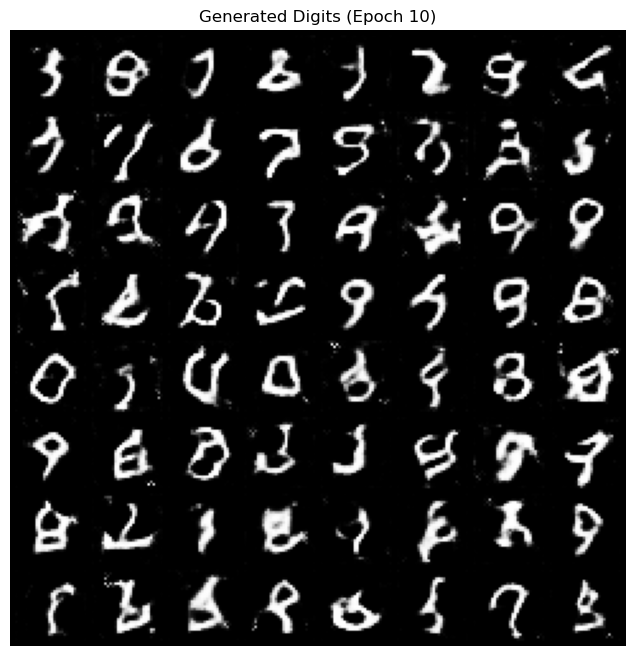

Epoch: [20/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0463
Generator loss = 0.0881


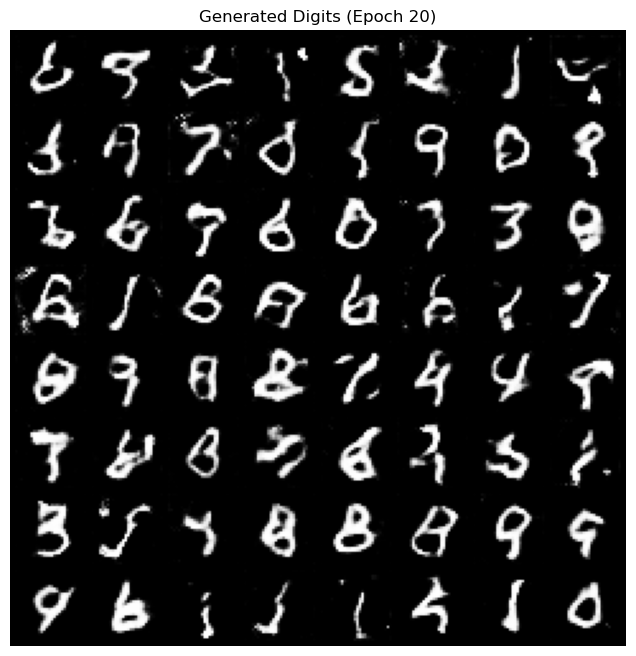

Epoch: [30/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0421
Generator loss = 0.0201


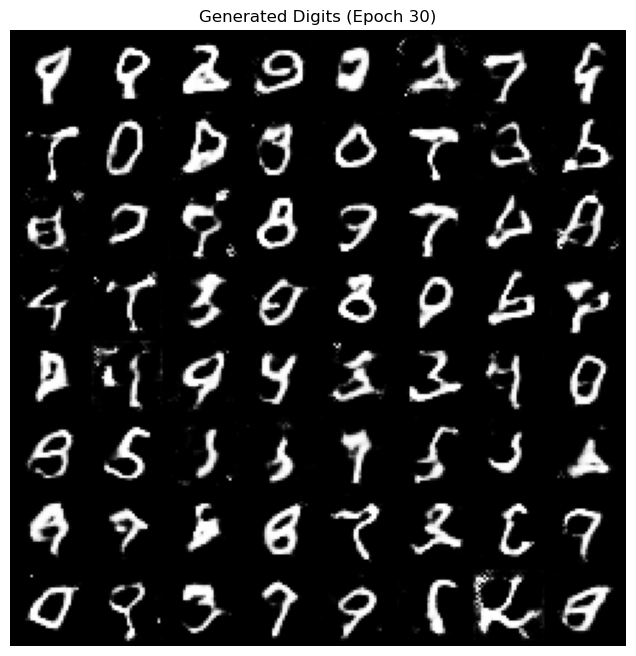

Epoch: [40/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0343
Generator loss = -0.0200


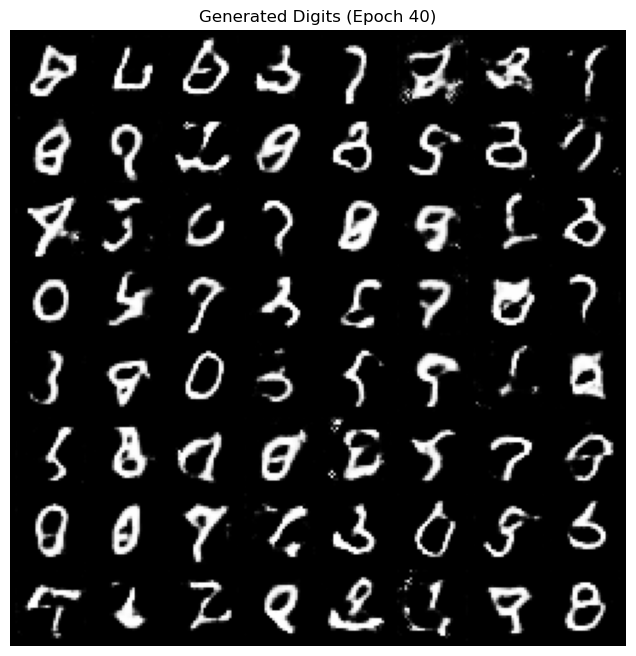

Epoch: [50/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0412
Generator loss = 0.0603


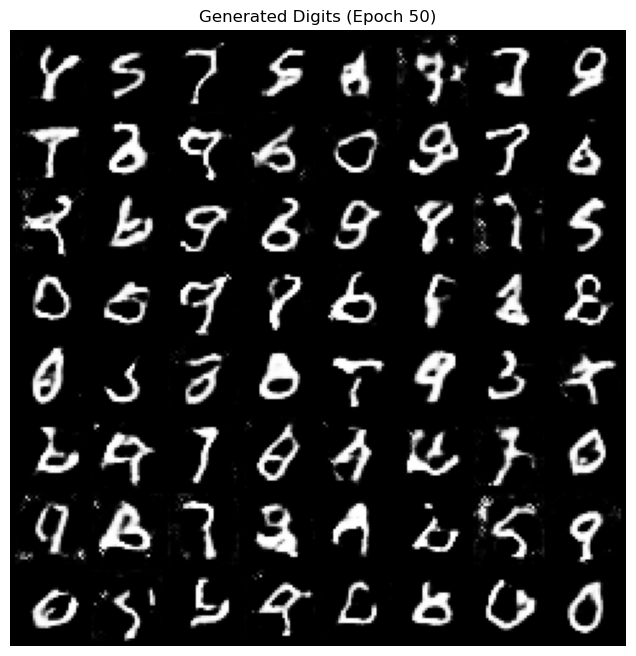

Epoch: [60/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0304
Generator loss = 0.0519


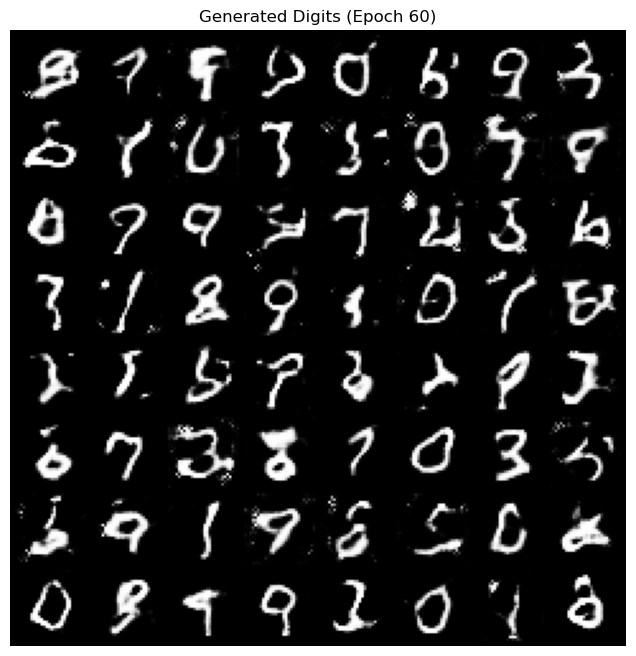

Epoch: [70/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0242
Generator loss = 0.1306


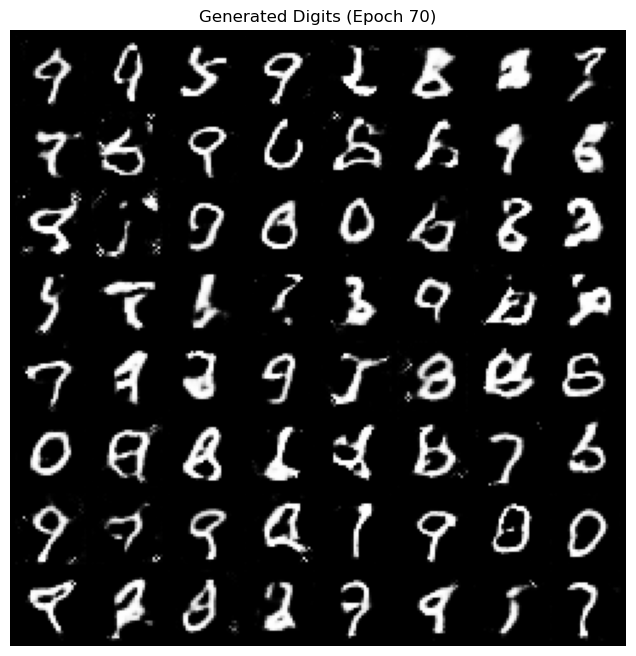

Epoch: [80/100]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = -0.0208
Generator loss = 0.0141


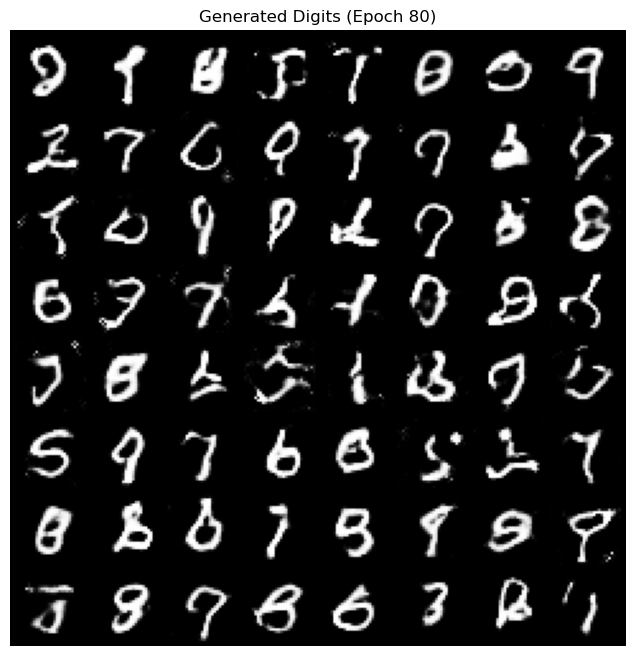

In [ ]:
gan_trainer(train_loader,
            num_epochs=num_epochs,
            critic_rounds=critic_rounds,
            generator_rounds=generator_rounds
            )

In [ ]:
# Check training time
elapsed = time.perf_counter() - start
print(f"Training time: {datetime.timedelta(seconds=int(elapsed))} ({elapsed:.2f} s)")

Training time: 0:03:12 (192.17 s)
